In [2]:
import torch
import networkx as nx
from torch.utils.data import Dataset, DataLoader
import numpy as np 
from sklearn.metrics import r2_score 
import time 
from matplotlib import pyplot as plt 


import sys 
sys.path.append('../src/')

from src.models.NN import NN
from src.data.LincsDataset import LincsDataset
from src.models import utils 

%load_ext autoreload
%autoreload 2

In [3]:
if torch.cuda.is_available() & False:
    device = 'cuda'
else: 
    device = 'cpu'

print('using device', device)

using device cpu


In [4]:
data = torch.load('./processed_data/Data.pt')

In [5]:
train_ids = np.load('./processed_data/train_obs.npy', allow_pickle=True)
train_dataset = LincsDataset(root='./processed_data/', sig_ids=train_ids)
train_loader = DataLoader(train_dataset, batch_size=100, num_workers=4, shuffle=True)

test_ids = np.load('./processed_data/test_obs.npy', allow_pickle=True)
test_dataset = LincsDataset(root='./processed_data/', sig_ids=test_ids)
test_loader = DataLoader(test_dataset, batch_size=50, num_workers=4, shuffle=True)

In [6]:
model = NN(in_channels=int(data.input_node_mask.sum().item()), 
           hidden_channels=180, 
           out_channels=int(data.output_node_mask.sum().item()), 
           layers=2, 
           dropout=0.33, 
           nonlin=torch.nn.ELU)

n_params = sum([p.numel() for p in model.parameters()])
print('# params', n_params)

# params 257728


In [7]:
optim = torch.optim.Adam(model.parameters(), lr=1e-2)
crit = torch.nn.MSELoss()

In [8]:
for epoch in range(10):
    big_tic = time.time()
    model = model.train()
    losses = []
    for i,(x, y, sig_id) in enumerate(train_loader): 
        tic = time.time()
        optim.zero_grad() 

        x = x[:, data.input_node_mask].to(device).squeeze(-1)
        yhat = model(x)
        y = y.to(device).squeeze(-1)[:, data.output_node_mask]

        loss = crit(yhat, y)
        loss.backward()
        optim.step()

        with torch.no_grad(): 

            yhat = yhat.detach().cpu().numpy() 
            y = y.detach().cpu().numpy() 
            
            r2 = r2_score(y, yhat, multioutput='variance_weighted')
            r_flat = np.corrcoef(y.ravel(), yhat.ravel())[0,1]
            losses.append(loss.item())

            print(f'epoch: {epoch} || batch: {i}/{len(train_loader)} || loss: {loss.item():.3f} || r2: {r2:.3f} || r (flat): {r_flat:.2f} || elapsed: {(time.time() - tic):.2f} s' , end='\r')

    loss_train = np.mean(losses)

    y,yhat,sig_ids = utils.predict_nn(test_loader, model, data, device)
    r2_test = r2_score(y, yhat, multioutput='variance_weighted')
    r_flat_test = np.corrcoef(y.ravel(), yhat.ravel())[0,1]

    print(f'Epoch: {epoch} || loss (train): {loss_train:.3f} || r2 (test): {r2_test:.2f} || r flat (test): {r_flat_test:.2f} || elapsed: {(time.time() - big_tic)/60:.2f} min')

Epoch: 0 || loss (train): 3.557 || r2 (test): -0.09 || r flat (test): 0.22 || elapsed: 0.04 min
Epoch: 1 || loss (train): 2.760 || r2 (test): 0.12 || r flat (test): 0.48 || elapsed: 0.03 min
Epoch: 2 || loss (train): 2.511 || r2 (test): -1.14 || r flat (test): 0.43 || elapsed: 0.03 min
Epoch: 3 || loss (train): 2.453 || r2 (test): 0.24 || r flat (test): 0.58 || elapsed: 0.04 min
Epoch: 4 || loss (train): 2.412 || r2 (test): 0.23 || r flat (test): 0.57 || elapsed: 0.03 min
Epoch: 5 || loss (train): 2.381 || r2 (test): 0.20 || r flat (test): 0.56 || elapsed: 0.03 min
Epoch: 6 || loss (train): 2.364 || r2 (test): 0.13 || r flat (test): 0.51 || elapsed: 0.03 min
Epoch: 7 || loss (train): 2.351 || r2 (test): 0.20 || r flat (test): 0.56 || elapsed: 0.03 min
Epoch: 8 || loss (train): 2.333 || r2 (test): 0.22 || r flat (test): 0.56 || elapsed: 0.03 min
Epoch: 9 || loss (train): 2.334 || r2 (test): 0.21 || r flat (test): 0.57 || elapsed: 0.03 min


In [9]:
y,yhat,sig_ids = utils.predict_nn(test_loader, model, data, device)

In [10]:
r2_score(y, yhat, multioutput='variance_weighted')

0.2141708228892042

In [11]:
np.corrcoef(y.ravel(), yhat.ravel())[0,1]

0.5673958113834687

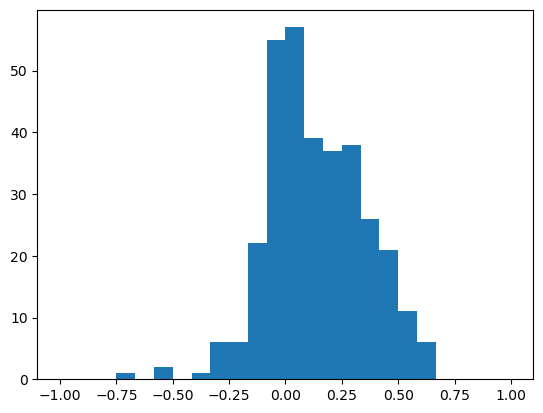

In [12]:
gene_r2 = r2_score(y, yhat, multioutput='raw_values')
np.save('./nn_test_gene_r2.npy', gene_r2)

plt.figure()
plt.hist(gene_r2, bins=np.linspace(-1,1,25))
plt.show()